In [1]:
%matplotlib inline

# Cargar una imagen con skimage

from skimage import io

filename = os.path.join(skimage.data_dir, 'camera.png')

camera = io.imread(filename)

1) Hacer crop a la zona metiendo los parámetros manualmente
1.1) Hacer crop a la zona obteniendo parámetros

2) Quita ruido y skeletoniza

3) Transformada de Hough

In [29]:
#PASO 1
from skimage import io #Librerias para importar las imagenes

#PASO 2
from skimage import img_as_ubyte#Mostrar las 3 imagenes
from skimage.color import rgb2grey#Mostrar las 3 imagenes
from skimage.color import rgb2hsv#Mostrar las 3 imagenes
import numpy as np#Mostrar las 3 imagenes
import matplotlib.pyplot as plt#Mostrar las 3 imagenes

#PASO 3
from skimage.filters import threshold_otsu

#PASO 4

#PASO 5
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image, remove_small_objects
from skimage.morphology import disk, reconstruction
from skimage.morphology import binary_erosion,rectangle,binary_dilation

#PASO 6
from skimage.transform import hough_line, hough_line_peaks,probabilistic_hough_line
from skimage.feature import canny
from skimage import data
##imports para el uso de interactive
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

#PASO 7

#PASO 8
import math

#PASO 9
import networkx as nx
from networkx.algorithms import approximation as apxa

#PASO 1
##Funcion Para leer una imagen a traves de scikit-Image (skimage)
#dandole el path de la imagen
#Return: Img imagen leida
def leerImagen():
    pathImg="/Users/Ismael/Desktop/TFG_DietaPorDientes/TrabajosPasadosPorJose/dietaJose/ATP02 UE4 46.jpg"
    img = io.imread(pathImg)
    return img

#PASO 2
#Entrada: img imagen original leida anteriormente
#Pasamos la imagen al espacio de color RGB y nos quedamos con el canal rojo
#Pasamos la imagen al espacio de color HSV
#Normalizamos la imagen del espacio de color HSV para utilizar que distancia 
#  al rojo tenemos y poder hacer el theshold
#Return: distance_red distancia de cada pixel al rojo apra luego hacer el threshold
def distanciaAlRojo(img):
    rojo=img[:,:,0]
    imgHSV=rgb2hsv(img)
    distance_red = rgb2grey(1 - np.abs(imgHSV - (0, 1, 0)))
    return distance_red

#PASO 3
#Entrada: distance_red distancia de cada pixel al rojo apra luego hacer el threshold
#Binarizamos la imagen para obtener una clara diferenciacion entre 
#el fondo y las lineas que queremos detectar
#Return: imgBin imagen binarizada
def binarizar(distance_red):
    threshold_global_otsu = threshold_otsu(distance_red)
    imgBin = distance_red >= threshold_global_otsu
    return imgBin

#PASO 4
#Entrada:  imgBin imagen binarizada
#Como la imagen no hay qeu procesarla completa porque solo tiene una region
#marcada con lineas tenemos qque recortarla
#Return: 
#    imgBinCrop: Es la imagen binarizada recortada a la region que queremos
#    imgCrop: Es la imagen original recortada a la region que queremos
def cropImg(imgBin,img):
    imgBinCrop = imgBin[0:750,500:1500]
    imgCrop = img[0:750,500:1500]

    #imgBinCrop = imgBin
    #imgCrop = img

    #imgBinCrop = imgBin[0:750,0:750]
    #imgCrop = img[0:750,0:750]
    return imgBinCrop,imgCrop

#PASO 5
#Entrada: imgBinCrop Es la imagen binarizada recortada a la region que queremos
#Esta funcion en lo que consiste es qeu entrando la imagen binarizada 
#reduzcamos el tamaño de las lineas para que la deteccion tenga menos
#incertidumbre y sea mas rápida la deteccion de lineas
#Return: sinRuido Es la imagen una vez corregida la binarizacion apra que las 
#        lineas sean mas delgadas.
def reducirGrosor(imgBinCrop):
    selem2 = rectangle(8,1)
    selem = rectangle(3,1)
    #sinRuido = binary_dilation(imgBinCrop,selem2)
    #sinRuido = binary_erosion(imgBinCrop,selem)
    sinRuido = skeletonize(imgBinCrop)
    return sinRuido

#PASO 6
#Entrada:
#    threshold: Densidad de lineas 
#    line_length: Distancia minima de las lineas que calcula.
#    line_gap: Distancia a la que si estan los extremos de las rectas las una
#    sinRuido:Es la imagen una vez corregida la binarizacion apra que las 
#        lineas sean mas delgadas.
#Esta funcion lo que va a hacer es calcular los segmentos(ORIGEN"Ox,Oy" Y FIN "FX,FY") 
#de cada una de las lineas que se han detectado en la imagen binarizada atraves de la 
#funcion probabilistica de la transformada de hough
#Return: lines Lista de todos los segmentos que ha detectado.
def proHough(threshold,line_length,line_gap,sinRuido):
    lines = probabilistic_hough_line(sinRuido, threshold, line_length, line_gap)
    return lines 

#PASO 7
#------------------Funciones auxiliares para la union de segmentos----------------------
#Entrada:
#        seg1: ((px,py),(fx,fy)) Puntos de inicio y fin del segmento 1
#        seg2: ((px,py),(fx,fy)) Puntos de inicio y fin del segmento 1
#Esta funcion devuelve la distancia entre el segmento 1 y el 2
#Return segments_distance() Funcion que calcula la distancia entre dos segmentos
def segmentsDistance(seg1, seg2):
    return segments_distance(seg1[0][0], seg1[0][1], seg1[1][0], seg1[1][1],
                             seg2[0][0], seg2[0][1], seg2[1][0], seg2[1][1])
#Entrada:
#        x11: Segmento 1 Punto 1 coordedana x
#        y11: Segmento 1 Punto 1 coordedana y
#        x12: Segmento 1 Punto 2 coordedana x
#        y12: Segmento 1 Punto 2 coordedana y 
#        x21: Segmento 2 Punto 1 coordedana x
#        y21: Segmento 2 Punto 1 coordedana y
#        x22: Segmento 2 Punto 2 coordedana x
#        y22: Segmento 2 Punto 2 coordedana y
#Funcion que calcula la distancia entre dos segmentos que no se cruzan 
#RETURN: min(distances) la distancia minima de todas las posibles distancias
def segments_distance(x11, y11, x12, y12, x21, y21, x22, y22):
    """distance between two segments in the plane:
    one segment is (x11, y11) to (x12, y12)
    the other is   (x21, y21) to (x22, y22)
    """
    if segments_intersect(x11, y11, x12, y12, x21, y21, x22, y22): 
            return 0
    # try each of the 4 vertices w/the other segment
    distances = []
    distances.append(point_segment_distance(x11, y11, x21, y21, x22, y22))
    distances.append(point_segment_distance(x12, y12, x21, y21, x22, y22))
    distances.append(point_segment_distance(x21, y21, x11, y11, x12, y12))
    distances.append(point_segment_distance(x22, y22, x11, y11, x12, y12))
    return min(distances)
#Entrada:
#        x11: Segmento 1 Punto 1 coordedana x
#        y11: Segmento 1 Punto 1 coordedana y
#        x12: Segmento 1 Punto 2 coordedana x
#        y12: Segmento 1 Punto 2 coordedana y 
#        x21: Segmento 2 Punto 1 coordedana x
#        y21: Segmento 2 Punto 1 coordedana y
#        x22: Segmento 2 Punto 2 coordedana x
#        y22: Segmento 2 Punto 2 coordedana y
#Funcion boleana que calcula si dos segmentos se cruzan o no
#RETURN: true/false si se cruzan o no 
def segments_intersect(x11, y11, x12, y12, x21, y21, x22, y22):
    """ whether two segments in the plane intersect:
      one segment is (x11, y11) to (x12, y12)
      the other is   (x21, y21) to (x22, y22)
    """
    dx1 = x12 - x11
    dy1 = y12 - y11
    dx2 = x22 - x21
    dy2 = y22 - y21
    delta = dx2 * dy1 - dy2 * dx1
    if delta == 0: 
        return False  # parallel segments
    s = (dx1 * (y21 - y11) + dy1 * (x11 - x21)) / delta
    t = (dx2 * (y11 - y21) + dy2 * (x21 - x11)) / (-delta)
    return (0 <= s <= 1) and (0 <= t <= 1)
#Entrada:
#        px: Punto coordenada x 
#        py: Punto coordenada y
#        x1: Punto 1 coordenada x 
#        y1: Punto 1 coordenada y
#        x2: Punto 2 coordenada x 
#        y2: Punto 2 coordenada y
#Funcion que calcula la distancia desde un punto dado a un segmento.
#RETURN: DIstancia desde el punto al segmento
def point_segment_distance(px, py, x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    if dx == dy == 0:  # the segment's just a point
        return math.hypot(px - x1, py - y1)

    # Calculate the t that minimizes the distance.
    t = ((px - x1) * dx + (py - y1) * dy) / (dx * dx + dy * dy)

    # See if this represents one of the segment's
    # end points or a point in the middle.
    if t < 0:
        dx = px - x1
        dy = py - y1
    elif t > 1:
        dx = px - x2
        dy = py - y2
    else:
        near_x = x1 + t * dx
        near_y = y1 + t * dy
        dx = px - near_x
        dy = py - near_y

    return math.hypot(dx, dy)
#Entrada:
#        vA: Punto A
#        vB: Punto B
#Funcion que devuelve la multiplicacion de las coordenadas x de los dos puntos 
#mas la multiplicacion de las coordenadas y de los dos puntos
#Return: la multiplicacion de las coordenadas x de los dos puntos 
#        mas la multiplicacion de las coordenadas y de los dos puntos
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]
#Entrada:
#        lineA:linea o segmento A
#        lineB:linea o segmento A
#Funcion que dadas dos rectas calcula el angulo que forman entre ellas.
#Return ang_deg: Devuelve el angulo que forman dichas rectas en grados.
def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    if cos_ > 1: cos_ =1
    # Get angle in radians and then convert to degrees
    angle = math.acos(cos_)
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360

    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else: 
        return ang_deg
#Entrada:
#        epsilon1: Distancia que si superan dos rectas no une
#        epsilon2: Angulo que si superan dos rectas no une
#        lines: Lineas producidas al aplicar la transformada
#        G: Grafo donde añadir los nodos que tengamso que unir
#Funcion que combina las lineas cercanas producidas por la Transformada probabilistica
#de hough que cumplen ciertos parametros y las añade a un grafo. 
#RETURN: devolvemos el Grafo completo donde estan los nodos que hemso fusionado.
def combina(epsilon1,epsilon2,lines,G): 
    for i in range(len(lines)):
        G.add_node(i)

    for i in range(len(lines)-1):
        for j in range(i+1,len(lines)):
            distance = segmentsDistance(lines[i],lines[j])
            #print(angle)
            if distance <= epsilon1 :
                angle = ang(lines[i],lines[j])
                #print(distance)
                if angle <= epsilon2:
                    #print("combina ",i,j)
                    G.add_edge(i,j) 
    return G

#Entrada.
#        p1: Punto 1
#        p2: Punto 2
#Calculamos la distancia entre dos puntos.
#Return distancia entre los puntos.
def pointDistance(p1, p2):
    dx = p1[0] - p2[0]
    dy = p1[1] - p2[1]
    return (dx*dx + dy*dy)**0.5

#Entrada: segmentosList lista con todos los segmentos a combinar
#Combinamos los segmentos
#Lista con los segmentos combinados que calculamos con la teoria de grafos.
def combinaSegmentos(segmentosList):
    #print("combina",segmentosList)
    Xs=list(map(lambda x:[x[0][0],x[1][0]],segmentosList))
    Ys=list(map(lambda x:[x[0][1],x[1][1]],segmentosList))
    xMax=np.max(Xs)
    yMax=np.max(Ys)
    xMin=np.min(Xs)
    yMin=np.min(Ys)
    if (xMax,yMax) in set(map(lambda x:x[0],segmentosList)):
        #print("devuelvo",((xMax,yMax),(xMin,yMin)))
        return ((xMax,yMax),(xMin,yMin))
    else:
        #print("devuelvo",((xMax,yMin),(xMin,yMax)))
        return ((xMax,yMin),(xMin,yMax))
#Entrada.
#        k_components K_componentes del grafo en el que decimos que rectas tenemos que unir
#        lines lineas calculadas por la tranformada de hough
#Funcion que dadas las lineas calculadas y las que nos marca el grafo que tenemso que unir
#devuelve lso segmentos que de verdad ha detectado el algoritmo
def segmentosVerdad(k_components,lines):
    segmentosDeVerdad = []
    for i in range(len(k_components[1])):
        segmentos=list(map(lambda x:lines[x],k_components[1][i]))
        segmentosDeVerdad.append(combinaSegmentos(segmentos))
    return segmentosDeVerdad
#Entrada:
#        imagen: Imagen qeu queremso mostrar.
#        segmentos: segmentos que vamso a mostrar dentro de la imagen.
#Procedimiento que usaremos para msoitrar los datos calculados pero solo es apra pruebas
#esta funcion no sera transladada cuando necesitemos la interfaz(SOLO NOTEBOOK)
#Return: No tiene
def mostrar(imagen,segmentos):
    plt.figure(figsize=(20, 20)) 
    plt.imshow(imagen, cmap=plt.cm.gray)
    for line in segmentos:
        p0, p1 = line
        plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
    #fig.savefig('foo.jpg',bbox_inches='tight')
    print(len(segmentos),"hay 15 lineas realmente")

In [32]:
img=leerImagen()
distance_red=distanciaAlRojo(img)
imgBin=binarizar(distance_red)
imgBinCrop,imgCrop=cropImg(imgBin,img)
sinRuido=reducirGrosor(imgBinCrop)
lines=proHough(10,5,11,sinRuido)        
G=nx.Graph()
G=combina(8,4,lines,G)
k_components = apxa.k_components(G)
segmentosDeVerdad=segmentosVerdad(k_components,lines)
segmentosDeVerdad

[((434, 12), (310, 323)),
 ((485, 467), (434, 643)),
 ((469, 251), (337, 15)),
 ((531, 293), (513, 79)),
 ((722, 182), (337, 184)),
 ((463, 340), (294, 19)),
 ((215, 572), (52, 681)),
 ((618, 485), (605, 708)),
 ((408, 740), (312, 593)),
 ((570, 318), (438, 726)),
 ((236, 430), (59, 634)),
 ((451, 3), (408, 121)),
 ((373, 219), (322, 324)),
 ((577, 278), (565, 36)),
 ((383, 443), (375, 718)),
 ((683, 51), (640, 189)),
 ((131, 133), (116, 19)),
 ((255, 342), (251, 138)),
 ((354, 115), (244, 371)),
 ((540, 196), (524, 7)),
 ((288, 91), (263, 153)),
 ((465, 0), (421, 137)),
 ((446, 160), (304, 400)),
 ((767, 204), (708, 114)),
 ((424, 0), (302, 301)),
 ((743, 383), (677, 19)),
 ((360, 384), (328, 312)),
 ((198, 328), (175, 548)),
 ((652, 0), (631, 199)),
 ((178, 4), (153, 107)),
 ((111, 275), (74, 468)),
 ((757, 53), (714, 210)),
 ((631, 436), (586, 284)),
 ((341, 145), (275, 21)),
 ((709, 468), (703, 271)),
 ((178, 109), (163, 150)),
 ((124, 236), (73, 189)),
 ((247, 187), (208, 409)),
 

0 hay 15 lineas realmente


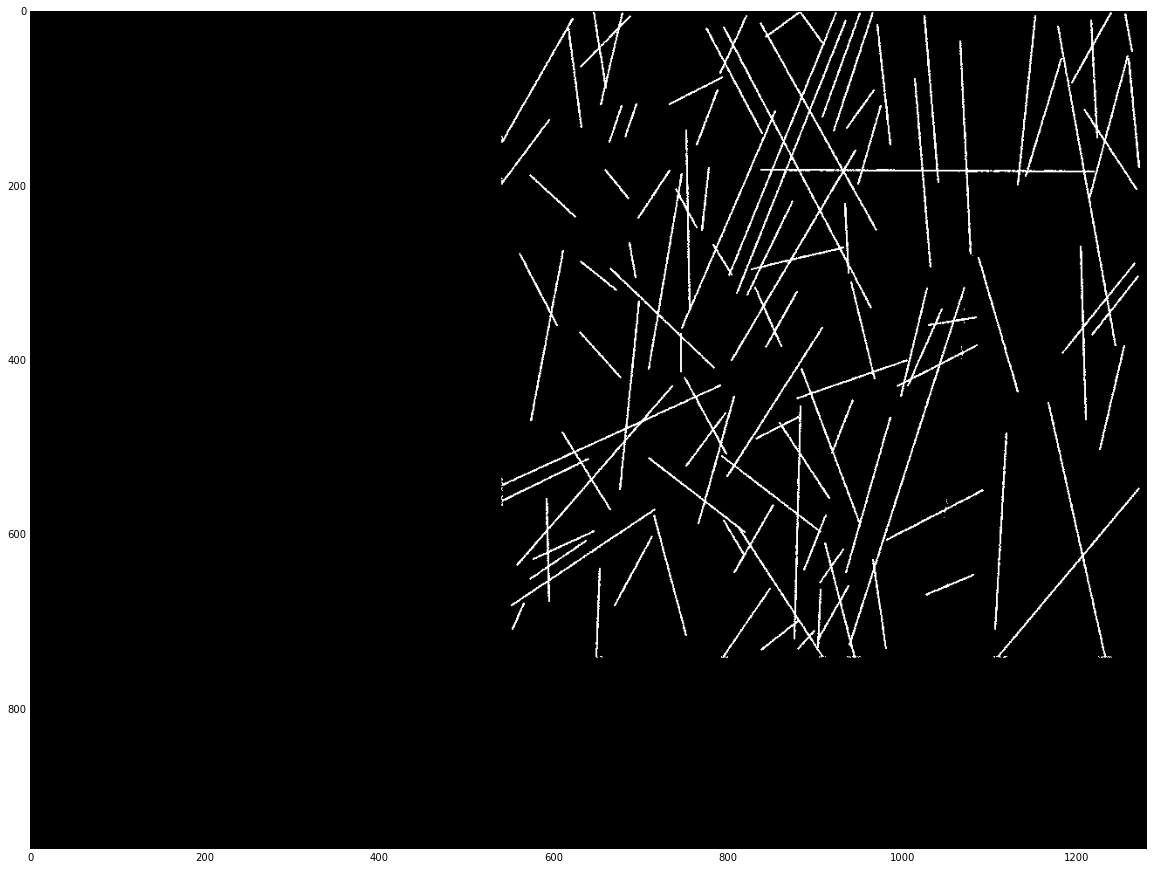

In [36]:
mostrar(imgBin,[])

0 hay 15 lineas realmente


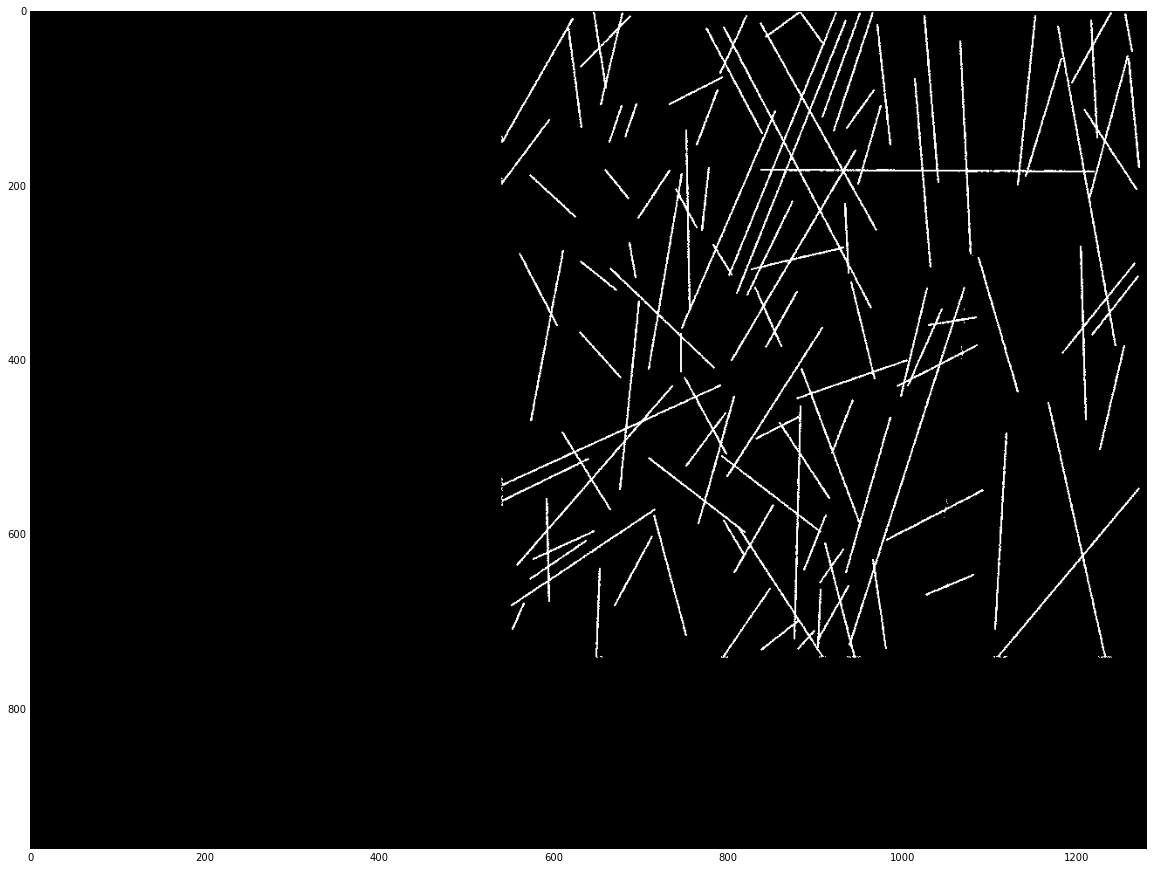

In [5]:
mostrar(imgBin,[])

0 hay 15 lineas realmente


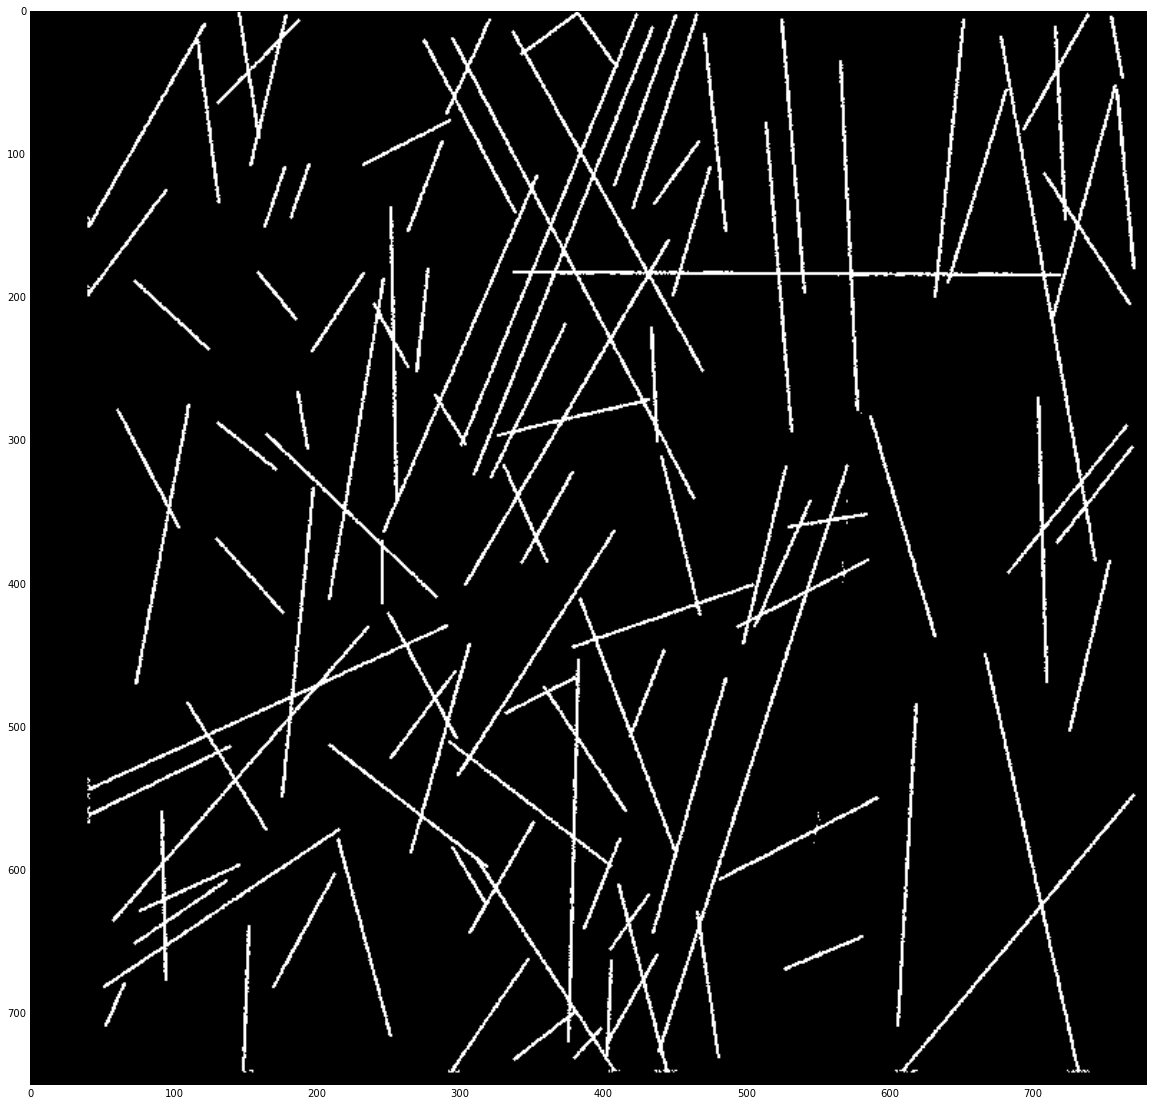

In [6]:
mostrar(imgBinCrop,[])

0 hay 15 lineas realmente


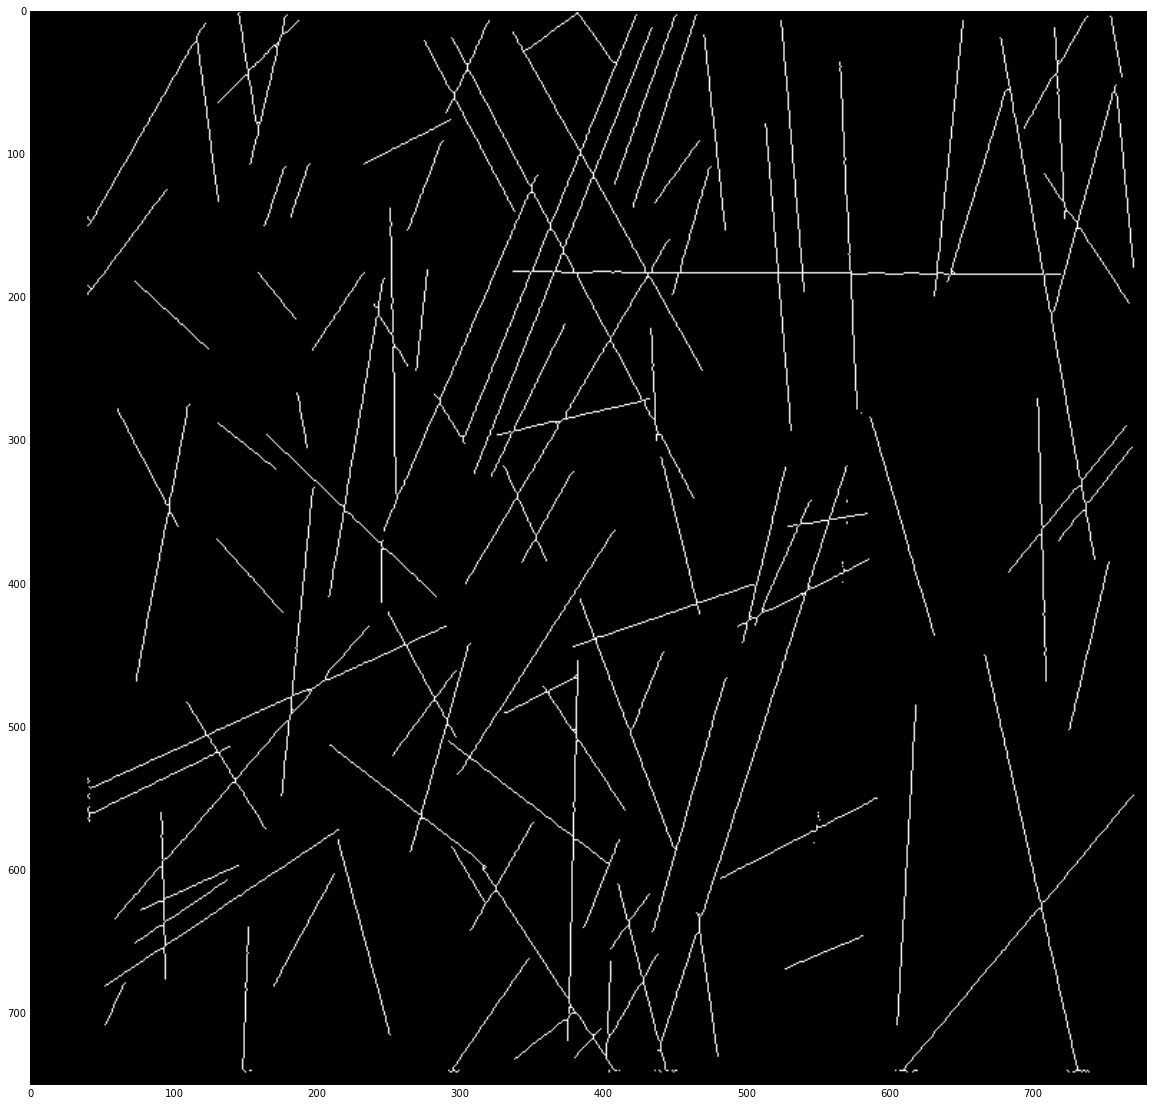

In [7]:
mostrar(sinRuido,[])

505 hay 15 lineas realmente


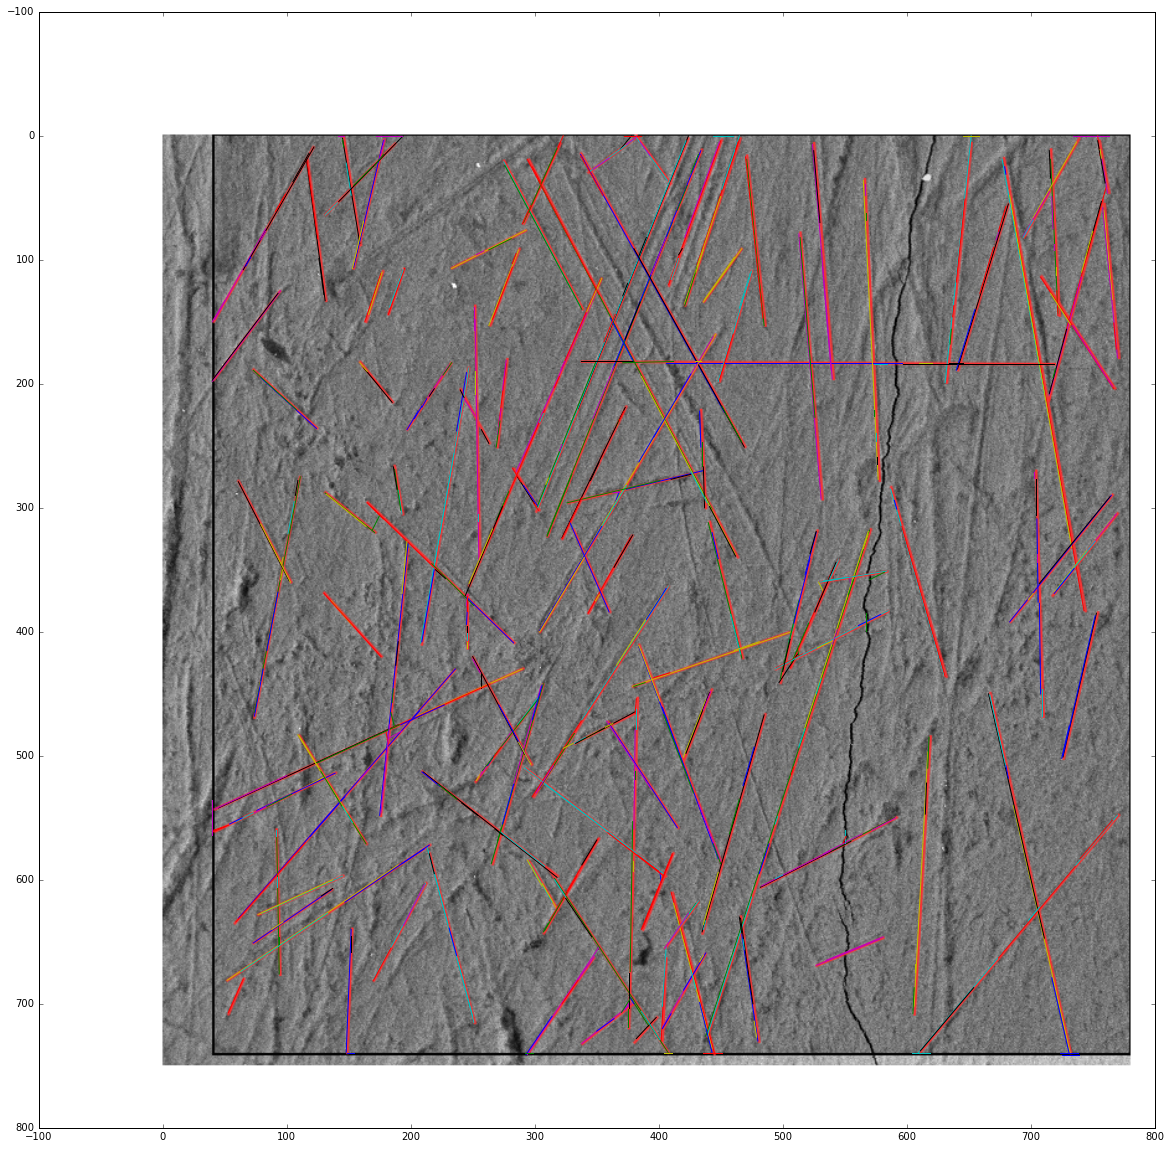

In [30]:
mostrar(imgCrop,lines)

112 hay 15 lineas realmente


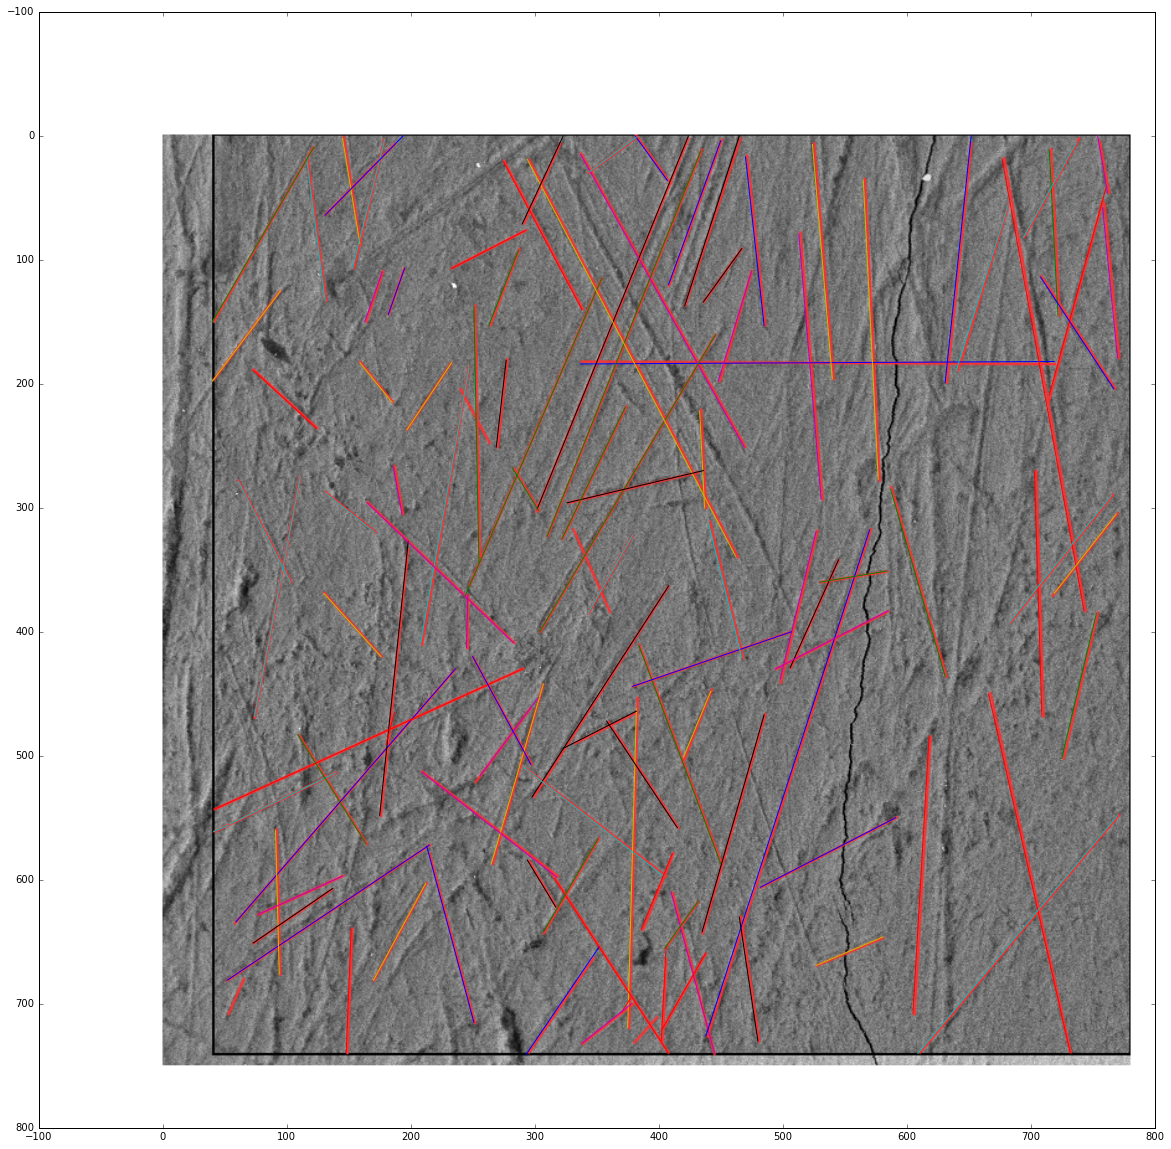

In [31]:
mostrar(imgCrop,segmentosDeVerdad)

505 hay 15 lineas realmente


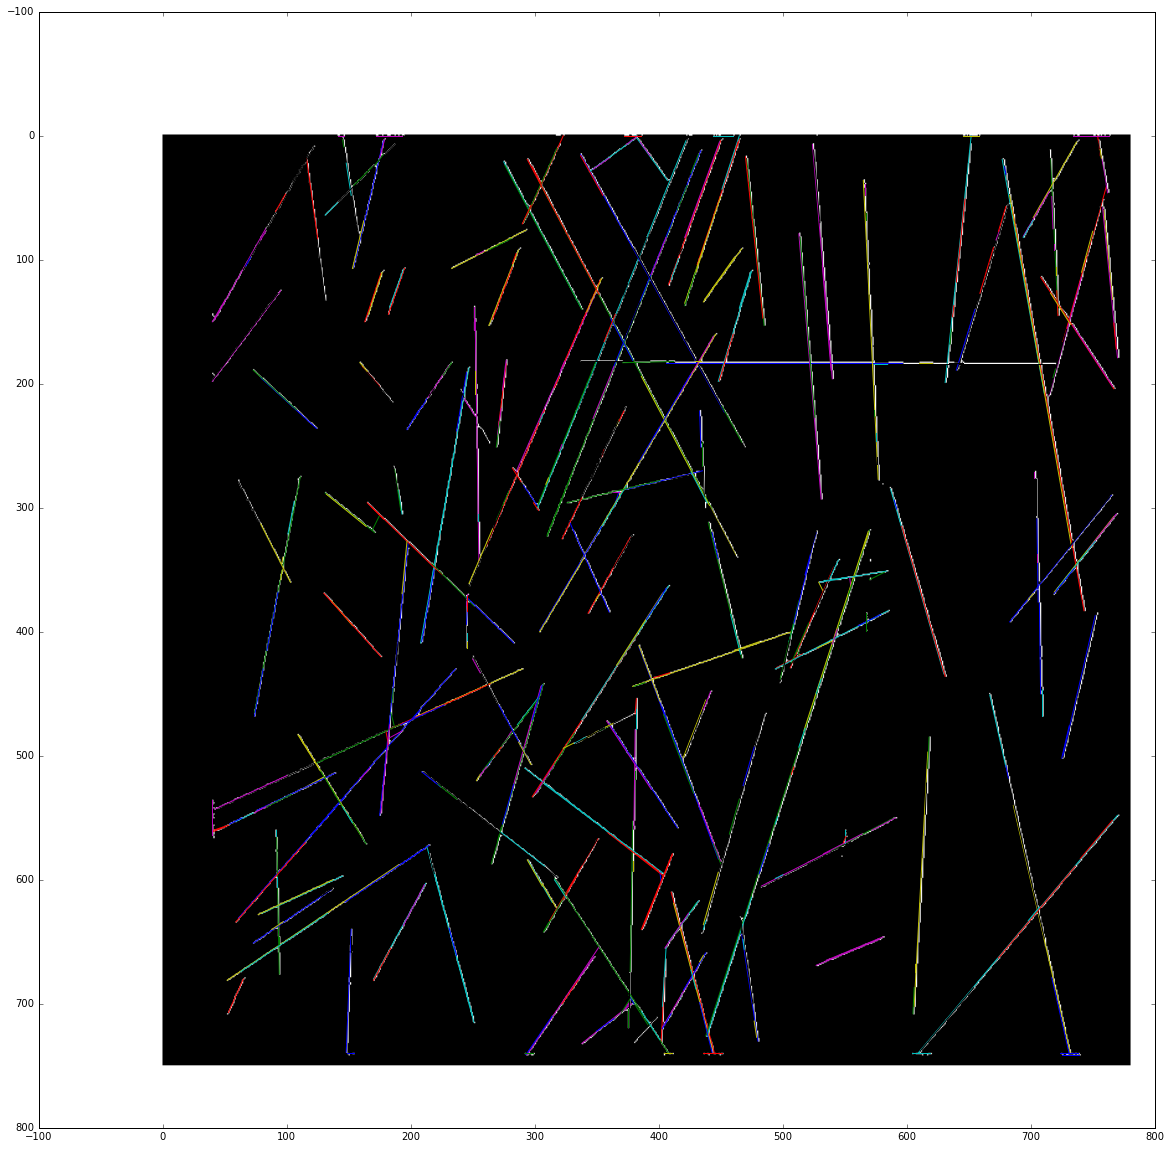

In [18]:
mostrar(sinRuido,lines)

112 hay 15 lineas realmente


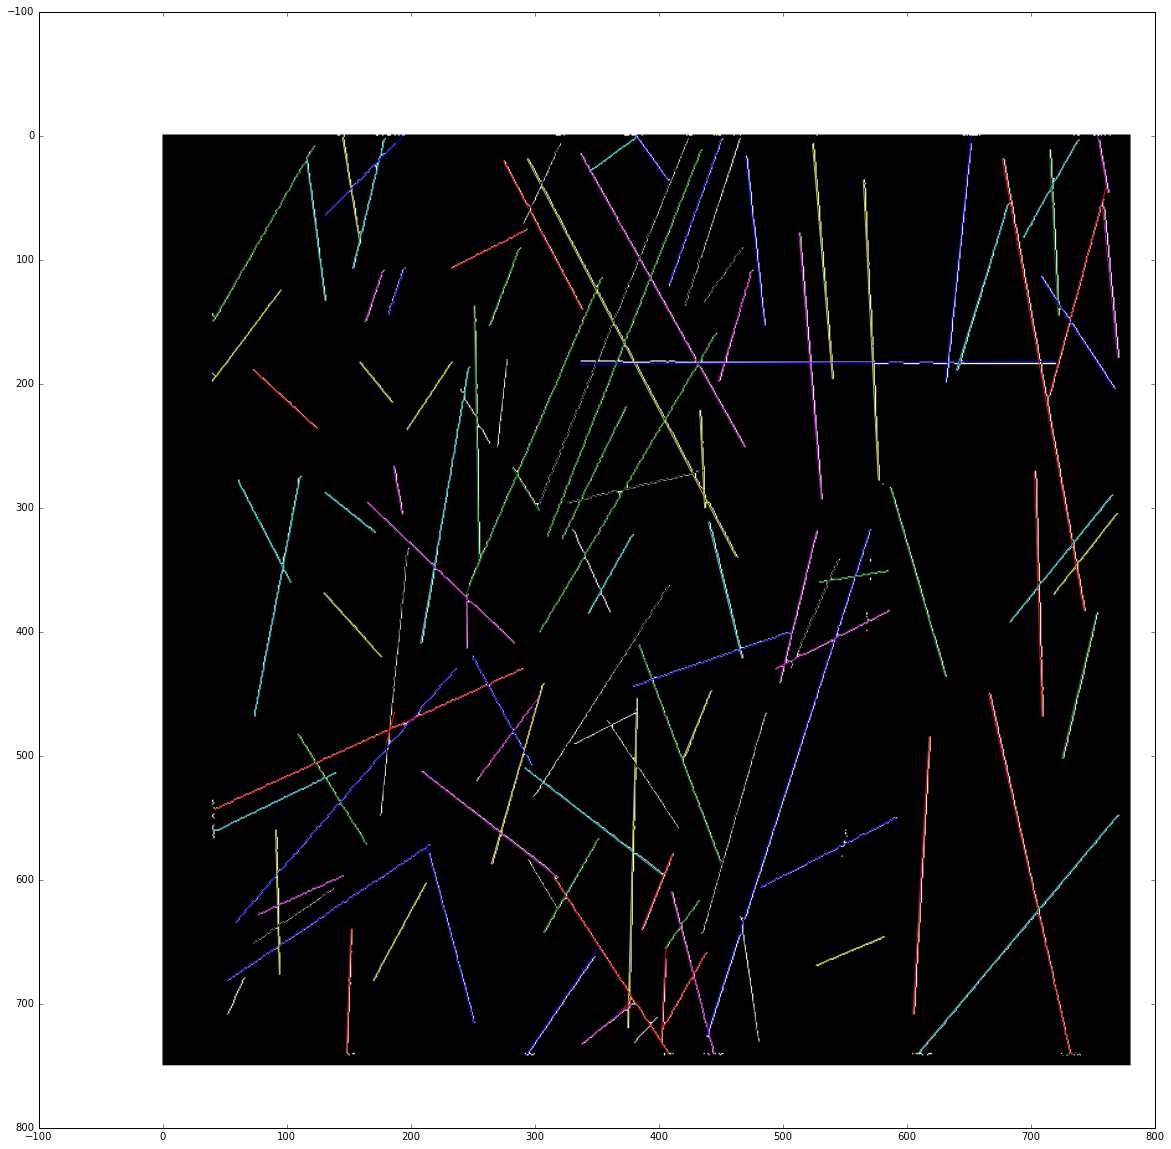

In [17]:
mostrar(sinRuido,segmentosDeVerdad)

[((406, 183), (573, 183)),
 ((405, 229), (294, 19)),
 ((446, 307), (350, 126)),
 ((468, 250), (339, 18)),
 ((302, 301), (422, 4)),
 ((577, 278), (574, 213)),
 ((375, 122), (424, 0)),
 ((574, 212), (565, 36)),
 ((251, 157), (251, 138)),
 ((253, 252), (253, 224)),
 ((253, 223), (253, 201)),
 ((460, 658), (570, 318)),
 ((254, 311), (254, 275)),
 ((531, 293), (516, 115)),
 ((208, 409), (223, 324)),
 ((252, 200), (252, 148)),
 ((526, 228), (513, 79)),
 ((469, 251), (404, 134)),
 ((438, 726), (515, 490)),
 ((713, 218), (757, 53)),
 ((711, 208), (677, 19)),
 ((585, 183), (596, 183)),
 ((40, 150), (121, 10)),
 ((435, 642), (486, 466)),
 ((298, 533), (401, 374)),
 ((255, 344), (255, 312)),
 ((621, 184), (719, 184)),
 ((254, 274), (254, 253)),
 ((705, 344), (705, 326)),
 ((712, 210), (688, 75)),
 ((742, 380), (714, 221)),
 ((314, 311), (434, 12)),
 ((630, 434), (587, 285)),
 ((218, 352), (247, 187)),
 ((371, 183), (392, 183)),
 ((119, 564), (173, 502)),
 ((411, 68), (433, 13)),
 ((368, 290), (44

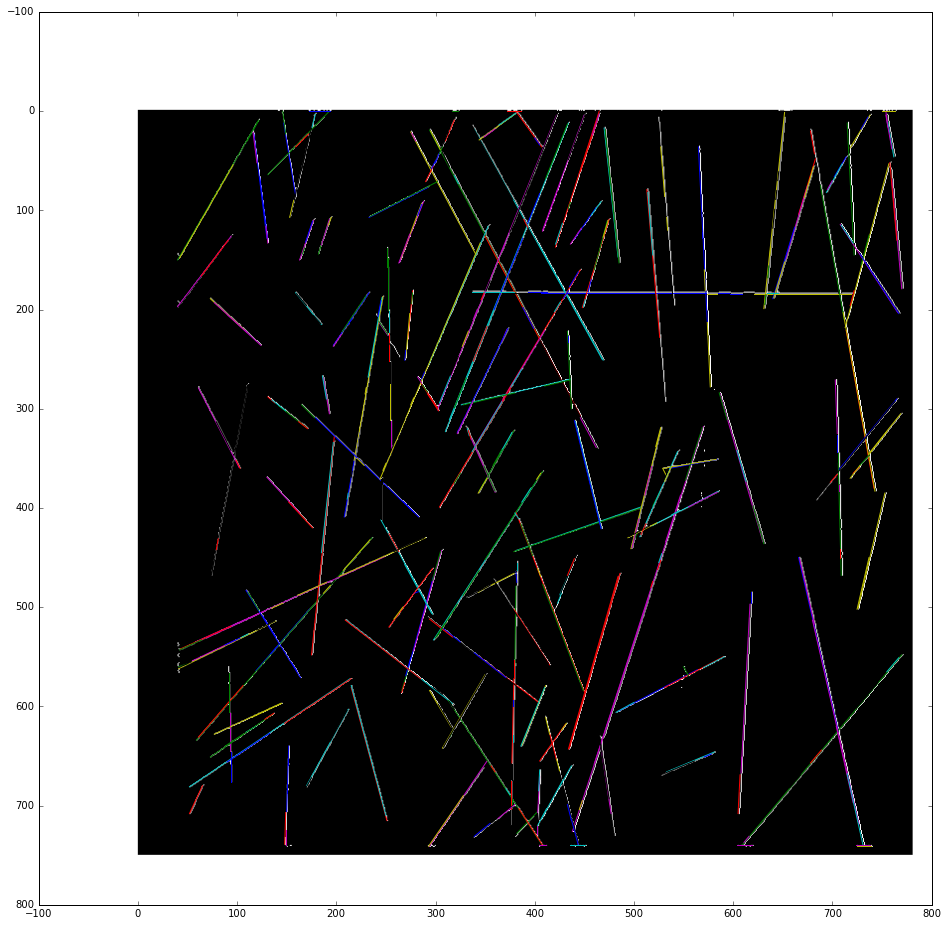

In [10]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

##imports para el uso de interactive
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt


def proHough(threshold,line_length,line_gap):

    lines = probabilistic_hough_line(sinRuido, threshold, line_length,
                                 line_gap)
    plt.figure(figsize=(16, 16)) 
    plt.imshow(sinRuido, cmap=plt.cm.gray)
    for line in lines:
        p0, p1 = line
        plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
    #return None 
    return lines;
m=proHough(10,5,3)
w = interactive(proHough, threshold=13, line_length=6,line_gap=8)#
display(w)
#13/5/5